<a href="https://colab.research.google.com/github/RyanChen12035/w266-NLP/blob/main/w266_final_project_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Package installation and importation

In [1]:
!pip install pydot --quiet
!pip install tensorflow-datasets --quiet
!pip install transformers --quiet

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-705aab81-10ee-c90d-8571-06cee1362c30)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
import sklearn as sk
import os
from nltk.data import find
import matplotlib.pyplot as plt
import re

Download IMDB review data and split them into training and testing(validation)

In [5]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5ONS1/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5ONS1/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5ONS1/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [ ]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

In [8]:
MAX_SEQUENCE_LENGTH = 100

In [6]:
#allow us to get the hidden layer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased', output_hidden_states=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Training/Testing data tokenization

In [9]:
#BERT Tokenization of training and test data
#Embedding size of Bert tokenizer: 768
#Dictionary size of Bert tokenizer: 28,996


train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

In [ ]:
train_examples_str[:2]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development wa

In [10]:
#12 layers of transformer
#A drop out layer + dense layer with 100 hidden layer size on top + final layer with sigmoid as activation function

def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005,
                          output_cls_tokens=False):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    ### YOUR CODE HERE

    bert_base_model.trainable = True

    #input layers of BERT, shape (batch, max_sequence_length), model will be fit with bert_train_tokenized
    input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids')
    attention_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    inputs = [input_ids, token_type_ids, attention_mask]

    #BERT output, last_hidden_state shape (batch, max_sequence_length, embedding dimensions)
    bert_output = bert_base_model(input_ids=input_ids,
                                  token_type_ids=token_type_ids,
                                  attention_mask=attention_mask,
                                  output_hidden_states=output_cls_tokens)

    #Extract the CLS token's output, the embedding representation of first token of every sentence, shape(batch, embedding dimensions)
    cls_token_output = bert_output[0][:, 0, :] # CLS token output from the last layer

    #Add a dropout layer
    x = Dropout(dropout)(cls_token_output)

    #Add a fully connected layer for classification
    x = Dense(hidden_size, activation='relu')(x)

    #Final output layer for classification, assuming it's binary task
    output = Dense(1, activation='sigmoid')(x)


    # CLS output for each layer of transformer
    if output_cls_tokens:
        cls_outputs = [state[:, 0, :] for state in bert_output[2]] # CLS token outputs from all layers
        model_outputs = [output] + cls_outputs

    else:
        model_outputs = output


    #Model complie
    classification_model = Model(inputs=inputs, outputs=model_outputs)
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

    ### END YOUR CODE
    return classification_model

In [11]:
#bert_model
bert_cls_model_classification = create_bert_cls_model(bert_model, output_cls_tokens=False)
history_cls_bert= bert_cls_model_classification.fit(bert_train_inputs,
                                                    bert_train_labels,
                                                    epochs=2,
                                                    batch_size=8,
                                                    validation_data=(bert_test_inputs, bert_test_labels))

Epoch 1/2


2500/2500 [==============================] - 542s 201ms/step - loss: 0.4253 - accuracy: 0.8011 - val_loss: 0.3829 - val_accuracy: 0.8136
Epoch 2/2
2500/2500 [==============================] - 495s 198ms/step - loss: 0.2862 - accuracy: 0.8811 - val_loss: 0.3743 - val_accuracy: 0.8264


In [ ]:
tf.keras.backend.clear_session()

# Model parsing
###### 1. Refering to IMDB reviews, split the task of predicting sentiment into five sub-tasks and generate the corresponding test reviews.
###### 2. Applying logit lens method to find out the which layer of transformer is triggered by the test reviews.
###### 3. Modifiy the model so it can generate CLS outputs of each transformer layer inside the fine-tuned BERT model.
###### 4. Compare CLS from each layer with final CLS output and find out when the model start to understand the test review is about positive or negative. In other word, when the model understand the sub task?
###### 5. Dive into the neurons in hidden layer of FFN, and find out which neuron plays a major role of understanding the sub task.


In [ ]:
# Example test reviews
"""
1. Identifying Emotional Tone
Sub-Task: Determine the emotional tone of the review (e.g., positive, negative, neutral).
Test Reviews:
    EX1 "The movie's breathtaking scenery and exceptional soundtrack added depth to its rich storytelling." -> Positive Tone
    EX2 "The film was a letdown with its lackluster plot and uninspired performances." -> Negative Tone
2. Analyzing Subjective Statements
Sub-Task: Detect subjective statements or opinions in the review.
Test Reviews:
    EX3 "In my opinion, the film's portrayal of historical events was highly inaccurate." -> Subjective
    EX4 "The movie won three Academy Awards, including Best Picture." -> Objective
3. Evaluating Specific Aspects (Acting, Plot, Cinematography)
Sub-Task: Assess specific aspects of the movie like acting quality, plot development, and cinematography.
Test Reviews:
    EX5 "The acting was superb, with each character bringing depth and emotion to the screen." -> Positive Acting
    EX6 "The plot was predictable and lacked originality, making the movie quite boring." -> Negative Plot
4. Recognizing Extremes in Sentiment
Sub-Task: Identify reviews with extremely positive or negative sentiments.
Test Reviews:
    EX7 "This is possibly the worst movie ever made, with no redeeming qualities whatsoever." -> Extremely Negative
    EX8 "An absolute masterpiece, every moment was captivating and a joy to watch." -> Extremely Positive
5. Detecting Sarcasm or Irony
Sub-Task: Detect sarcasm or irony, which can often invert the apparent sentiment of a statement.
Test Reviews:
    EX9 "Oh great, another predictable rom-com, just what the world needs." -> Sarcasm
    EX10 "I loved how the movie ended abruptly without resolving any plot points." -> Irony
"""

# First reivews is positive tone and the second is negative tone
test_reviews = [
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "The acting was superb, with each character bringing depth and emotion to the screen.",
    "The plot was predictable and lacked originality, making the movie quite boring.",
    "This is possibly the worst movie ever made, with no redeeming qualities whatsoever.",
    "An absolute masterpiece, every moment was captivating and a joy to watch.",
    "Oh great, another predictable rom-com, just what the world needs.",
    "I loved how the movie ended abruptly without resolving any plot points."
]

# Tokenize the reviews
# 101:[CLS], 102:[SEP]
token_inputs = bert_tokenizer(test_reviews,
                            max_length=MAX_SEQUENCE_LENGTH,
                            truncation=True,
                            padding='max_length',
                            return_tensors='tf')

inputs = [token_inputs.input_ids,
        token_inputs.token_type_ids,
        token_inputs.attention_mask]

print(inputs)

In [57]:
#inference
outputs = bert_cls_model_classification(inputs)
outputs

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.06943023],
       [0.9903349 ],
       [0.06943023],
       [0.9903349 ],
       [0.99799466],
       [0.00317575],
       [0.00243789],
       [0.998243  ],
       [0.6085531 ],
       [0.9934649 ]], dtype=float32)>

In [58]:
# Create a model for analysis which includes the hidden states
#bert_model is fine-tuned now, don't have to re-train it. it's an object.
cls_layer_inside_finetunedBERT = create_bert_cls_model(bert_model, output_cls_tokens=True)

#get cls in each layers of transformer inside the fine-tuned BERT
predictions, *cls_hidden_states = cls_layer_inside_finetunedBERT.predict(inputs)
print(cls_hidden_states)

1/1 [==============================] - 3s 3s/step
[array([[ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01],
       [ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01],
       [ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01],
       ...,
       [ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01],
       [ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01],
       [ 4.5416489e-01,  9.7406425e-02, -2.1701567e-01, ...,
         6.0360257e-02, -3.0695461e-04, -1.2408945e-01]], dtype=float32), array([[ 0.28452983, -0.22469155, -0.08646453, ..., -0.00137751,
        -0.03577071, -0.03163073],
       [ 0.26170272, -0.20981811, -0.04525113, ..., -0.02268942,
        -0.05394149, -0.04099265],
       [ 0.2

In [60]:
#index 0 is embedding layer, and the following 12 layers are for transformer where number 12 is the final out.
print(len(cls_hidden_states))

#The output of first layer of transformer. Shape (batch, embedding dimensions)
print(cls_hidden_states[0][:].shape)
print(cls_hidden_states[12][0][:].shape)
print(cls_hidden_states[12][0][:10])
print(cls_hidden_states[:][0][0][:].shape)

13
(10, 768)
(768,)
[ 0.50611115 -0.37577623  0.11363251 -0.35600367 -0.577639    0.05737435
  0.22695258  0.1124417   0.7333339  -0.95794624]
(768,)


In [73]:
import numpy as np
from numpy.linalg import norm

def calculate_similarities(cls_outputs):
    # Number of examples and layers
    num_examples, num_layers = cls_outputs[0].shape[0], len(cls_outputs)

    # Initializing arrays to store the results
    cosine_similarities = np.zeros((num_examples, num_layers))
    dot_products = np.zeros((num_examples, num_layers))

    # Final layer's CLS output
    final_layer_output = cls_outputs[-1]

    # Calculating similarities and dot products
    for i in range(num_layers):
        for j in range(num_examples):
            # Extracting the CLS output for the current layer and example
            current_output = cls_outputs[i][j]

            # Cosine Similarity
            cosine_similarities[j, i] = np.dot(current_output, final_layer_output[j]) / (norm(current_output) * norm(final_layer_output[j]))

            # Dot Product
            dot_products[j, i] = np.dot(current_output, final_layer_output[j])

    return cosine_similarities, dot_products


simlarity = calculate_similarities(cls_hidden_states)

In [76]:
cosine_sims, dot_prods = simlarity
print(cosine_sims.shape)

(10, 13)


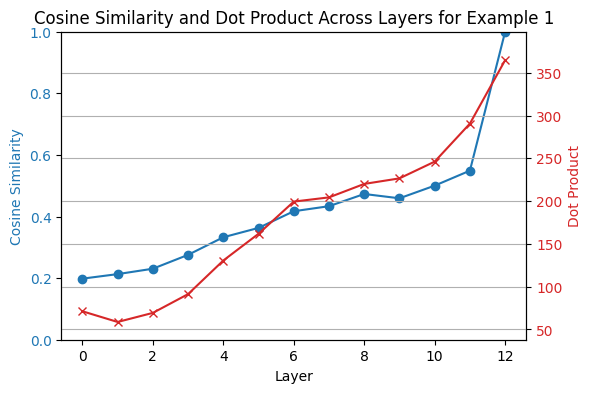

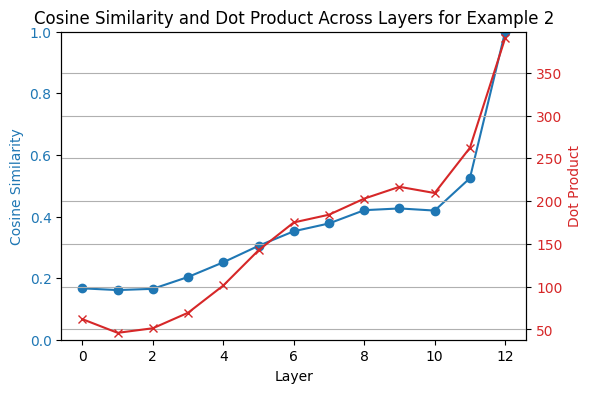

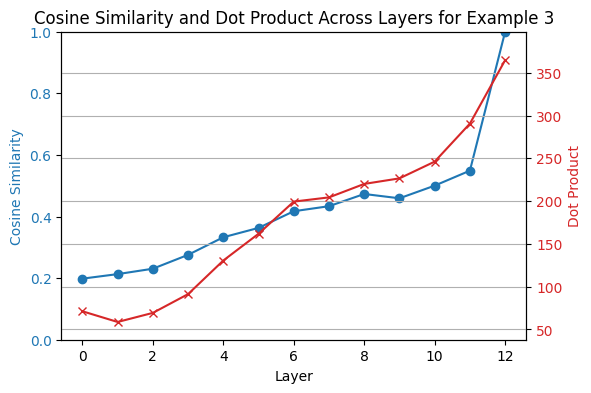

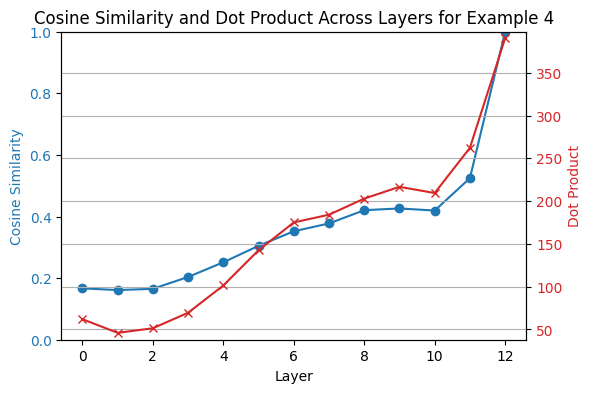

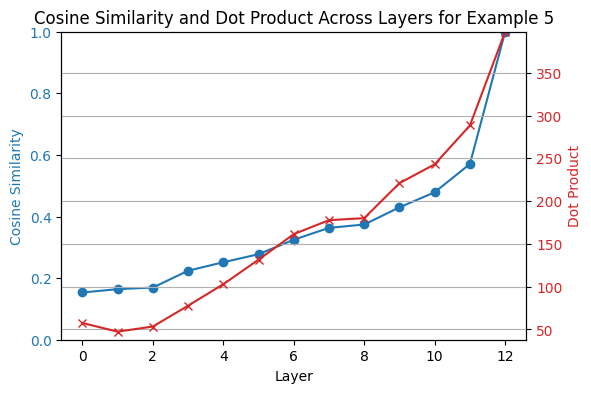

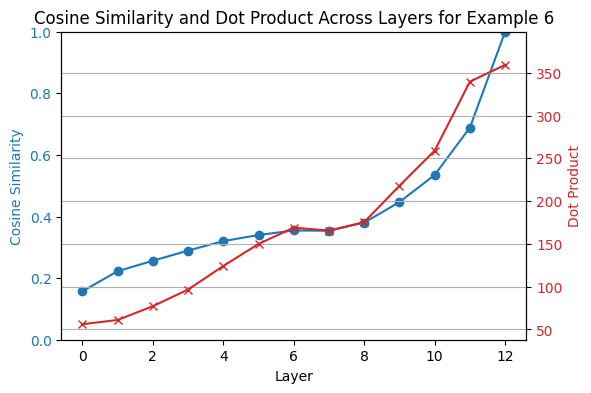

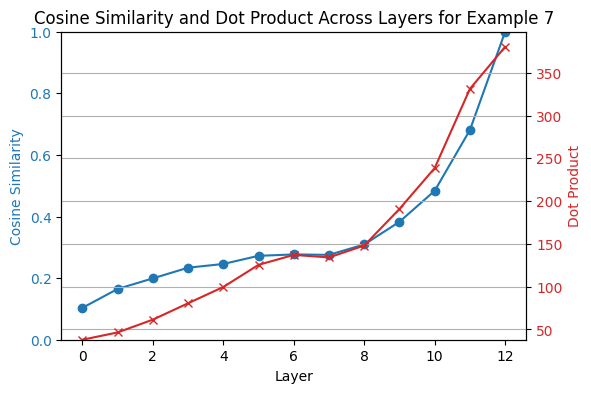

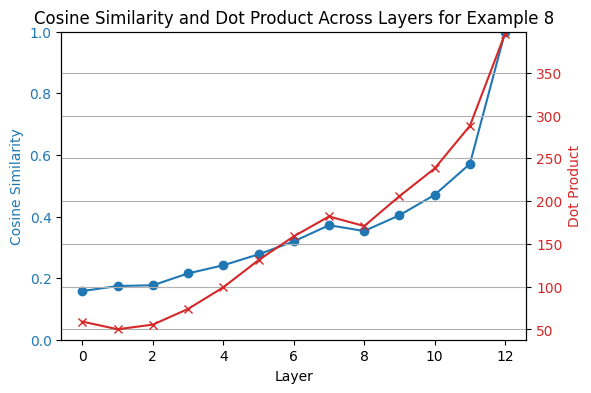

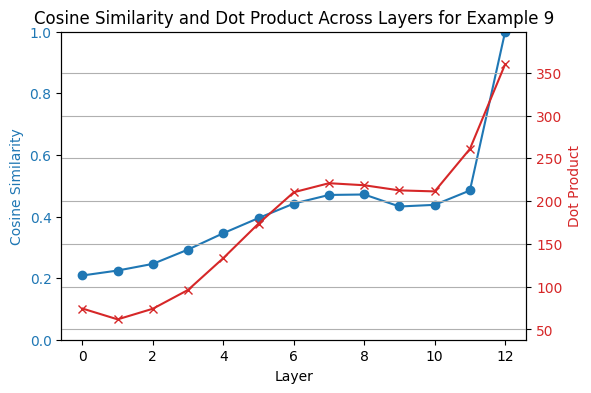

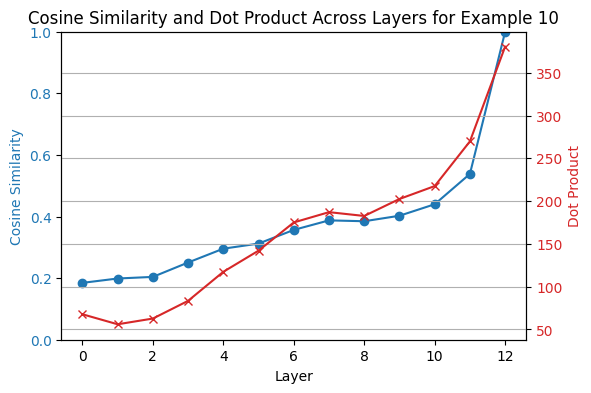

'\n1. Identifying Emotional Tone\nSub-Task: Determine the emotional tone of the review (e.g., positive, negative, neutral).\nTest Reviews:\n    EX1 "The movie\'s breathtaking scenery and exceptional soundtrack added depth to its rich storytelling." -> Positive Tone\n    EX2 "The film was a letdown with its lackluster plot and uninspired performances." -> Negative Tone\n2. Analyzing Subjective Statements\nSub-Task: Detect subjective statements or opinions in the review.\nTest Reviews:\n    EX3 "In my opinion, the film\'s portrayal of historical events was highly inaccurate." -> Subjective\n    EX4 "The movie won three Academy Awards, including Best Picture." -> Objective\n3. Evaluating Specific Aspects (Acting, Plot, Cinematography)\nSub-Task: Assess specific aspects of the movie like acting quality, plot development, and cinematography.\nTest Reviews:\n    EX5 "The acting was superb, with each character bringing depth and emotion to the screen." -> Positive Acting\n    EX6 "The plot wa

In [79]:
input_data = simlarity

# Unpacking the tuple
cosine_sims, dot_prods = input_data

# Plotting
num_examples = cosine_sims.shape[0]
layers = list(range(0, 13))  # 12 layers excluding the final layer

cosine_similarity_ylim = (0, 1)  # Cosine similarity typically ranges from -1 to 1
dot_product_ylim = (np.min(dot_prods), np.max(dot_prods))

for i in range(num_examples):
    # Create the plot for each example
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Cosine Similarity
    color = 'tab:blue'
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Cosine Similarity', color=color)
    ax1.plot(layers, cosine_sims[i], color=color, marker='o', label='Cosine Similarity')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(cosine_similarity_ylim)

    # Dot Product
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Dot Product', color=color)
    ax2.plot(layers, dot_prods[i], color=color, marker='x', label='Dot Product')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(dot_product_ylim)

    # Title and grid
    plt.title(f'Cosine Similarity and Dot Product Across Layers for Example {i+1}')
    plt.grid(True)

    # Show the plot
    plt.show()

"""
1. Identifying Emotional Tone
Sub-Task: Determine the emotional tone of the review (e.g., positive, negative, neutral).
Test Reviews:
    EX1 "The movie's breathtaking scenery and exceptional soundtrack added depth to its rich storytelling." -> Positive Tone
    EX2 "The film was a letdown with its lackluster plot and uninspired performances." -> Negative Tone
2. Analyzing Subjective Statements
Sub-Task: Detect subjective statements or opinions in the review.
Test Reviews:
    EX3 "In my opinion, the film's portrayal of historical events was highly inaccurate." -> Subjective
    EX4 "The movie won three Academy Awards, including Best Picture." -> Objective
3. Evaluating Specific Aspects (Acting, Plot, Cinematography)
Sub-Task: Assess specific aspects of the movie like acting quality, plot development, and cinematography.
Test Reviews:
    EX5 "The acting was superb, with each character bringing depth and emotion to the screen." -> Positive Acting
    EX6 "The plot was predictable and lacked originality, making the movie quite boring." -> Negative Plot
4. Recognizing Extremes in Sentiment
Sub-Task: Identify reviews with extremely positive or negative sentiments.
Test Reviews:
    EX7 "This is possibly the worst movie ever made, with no redeeming qualities whatsoever." -> Extremely Negative
    EX8 "An absolute masterpiece, every moment was captivating and a joy to watch." -> Extremely Positive
5. Detecting Sarcasm or Irony
Sub-Task: Detect sarcasm or irony, which can often invert the apparent sentiment of a statement.
Test Reviews:
    EX9 "Oh great, another predictable rom-com, just what the world needs." -> Sarcasm
    EX10 "I loved how the movie ended abruptly without resolving any plot points." -> Irony
"""

In [54]:
#Choose cosine similarity over dot produce since it's magnitude free and the CLS embedding has already been normalized

# def cosine_similarity(vec1, vec2):
#     dot_product = np.dot(vec1, vec2)
#     norm_v1 = np.linalg.norm(vec1)
#     norm_v2 = np.linalg.norm(vec2)
#     return dot_product / (norm_v1*norm_v2)

# vector_final = cls_hidden_states[-1][1][:]
# cos_sim = []
# dot_product = []
# for vec in cls_hidden_states:
#    cos_sim.append(cosine_similarity(vector_final, vec[1][:]))
#    dot_product.append(np.dot(vector_final, vec[1][:]))

# print(cos_sim)
# print(dot_product)

[0.16682453, 0.16120712, 0.16526026, 0.2037583, 0.2514048, 0.30486768, 0.35212964, 0.37749663, 0.42058378, 0.4262469, 0.419302, 0.5245415, 1.0000001]
[61.99547, 46.028305, 51.390682, 69.527016, 101.36177, 142.53394, 175.03557, 184.07321, 202.88808, 216.66663, 209.38483, 262.26413, 390.4041]


In [ ]:
#Review how to do the loop again, why can't I think of this way..
#Review how to draw lots of chart
#Look into the charts and make some conclusions.
#Next, neurons!!. compare with whom?